In [2]:
# HIDDEN

from datascience import *
import numpy as np
import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
# HIDDEN

def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

def slope(table, x, y):
    r = correlation(table, x, y)
    return r * np.std(table.column(y))/np.std(table.column(x))

def intercept(table, x, y):
    a = slope(table, x, y)
    return np.mean(table.column(y)) - a * np.mean(table.column(x))

def fit(table, x, y):
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

def residual(table, x, y):
    return table.column(y) - fit(table, x, y)

def scatter_fit(table, x, y):
    plots.scatter(table.column(x), table.column(y), s=20)
    plots.plot(table.column(x), fit(table, x, y), lw=2, color='gold')
    plots.xlabel(x)
    plots.ylabel(y)

In [4]:
# HIDDEN

def draw_and_compare(true_slope, true_int, sample_size):
    x = np.random.normal(50, 5, sample_size)
    xlims = np.array([np.min(x), np.max(x)])
    eps = np.random.normal(0, 6, sample_size)
    y = (true_slope*x + true_int) + eps
    tyche = Table().with_columns(
        'x', x,
        'y', y
    )

    plots.figure(figsize=(6, 16))
    plots.subplot(4, 1, 1)
    plots.scatter(tyche['x'], tyche['y'], s=20)
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title('True Line, and Points Created')

    plots.subplot(4, 1, 2)
    plots.scatter(tyche['x'],tyche['y'], s=20)
    plots.title('What We Get to See')

    plots.subplot(4, 1, 3)
    scatter_fit(tyche, 'x', 'y')
    plots.xlabel("")
    plots.ylabel("")
    plots.title('Regression Line: Estimate of True Line')

    plots.subplot(4, 1, 4)
    scatter_fit(tyche, 'x', 'y')
    plots.ylabel("")
    xlims = np.array([np.min(tyche['x']), np.max(tyche['x'])])
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title("Regression Line and True Line")

In [5]:
# HIDDEN

baby = Table.read_table('baby.csv')

### Inference for the True Slope ###

Our simulations show that if the regression model holds and the sample size is large, then the regression line is likely to be close to the true line. This allows us to estimate the slope of the true line.

We will use our familiar sample of mothers and their newborn babies to develop a method of estimating the slope of the true line. First, let's see if we believe that the regression model is an appropriate set of assumptions for describing the relation between birth weight and the number of gestational days.

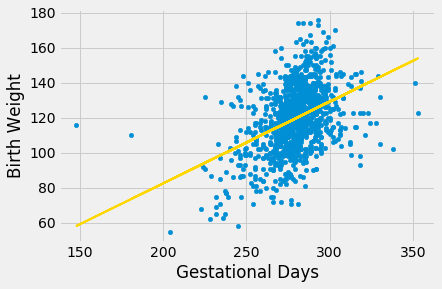

In [6]:
scatter_fit(baby, 'Gestational Days', 'Birth Weight')

In [7]:
correlation(baby, 'Gestational Days', 'Birth Weight')

0.40754279338885108

By and large, the scatter looks fairly evenly distributed around the line, though there are some points that are scattered on the outskirts of the main cloud. The correlation is 0.4 and the regression line has a positive slope. 

Does this reflect the fact that the true line has a positive slope? To answer this question, let us see if we can estimate the true slope. We certainly have one estimate of it: the slope of our regression line. That's about 0.47 ounces per day.

In [8]:
slope(baby, 'Gestational Days', 'Birth Weight')

0.46655687694921522

But had the scatter plot come out differently, the regression line would have been different and might have had a different slope. How do we figure out how different the slope might have been?

We need another sample of points, so that we can draw the regression line through the new scatter plot and find its slope. But from where will get another sample?

You have guessed it – we will *bootstrap our original sample*. That will give us a bootstrapped scatter plot, through which we can draw a regression line.

### Bootstrapping the Scatter Plot ###
We can simulate new samples by random sampling with replacement from the original sample, as many times as the original sample size. Each of these new samples will give us a scatter plot. We will call that a *bootstrapped scatter plot*, and for short, we will call the entire process *bootstrapping the scatter plot*.

Here is the original scatter diagram from the sample, and four replications of the bootstrap resampling procedure. Notice how the resampled scatter plots are in general a little more sparse than the original. That is because some of the original point do not get selected in the samples.

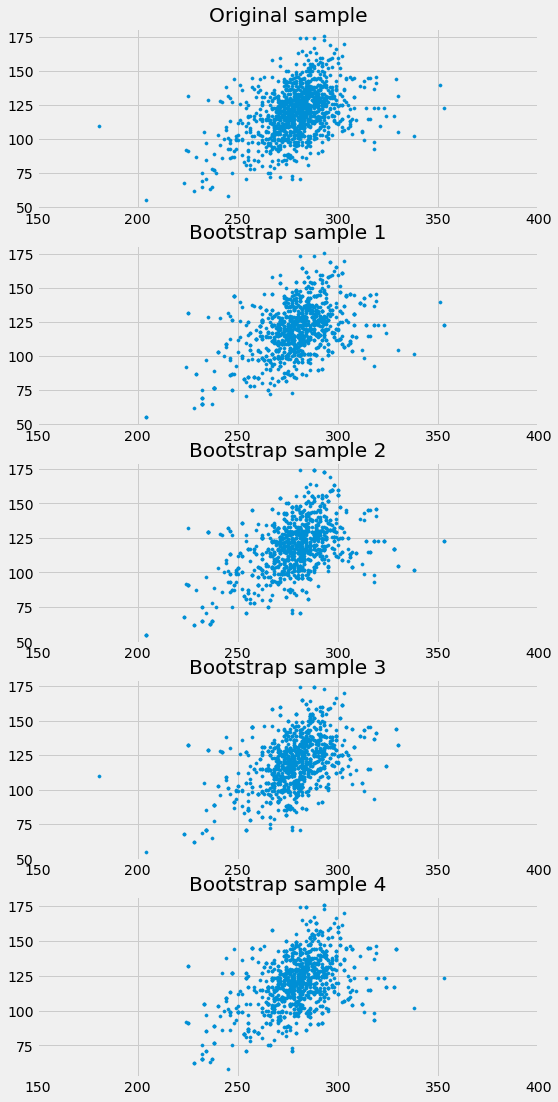

In [9]:
# HIDDEN

plots.figure(figsize=(8, 18))
plots.subplot(5, 1, 1)
plots.scatter(baby[1], baby[0], s=10)
plots.xlim([150, 400])
plots.title('Original sample')

for i in np.arange(1, 5, 1):
    plots.subplot(5,1,i+1)
    rep = baby.sample(with_replacement=True)
    plots.scatter(rep[1], rep[0], s=10)
    plots.xlim([150, 400])
    plots.title('Bootstrap sample '+str(i))

### Estimating the True Slope ###

We can bootstrap the scatter plot a large number of times, and draw a regression line through each bootstrapped plot. One way to visualize thie process is to simply draw the bootstrapped lines. Recall that by default, the `sample` method draws at random with replacement, the same number of times as the number of rows in the table. That is, `sample` generates a bootstrap sample by default.

In [22]:
slopes = make_array()
ints = make_array()
for i in np.arange(5000):
    bootstrap_sample = baby.sample()
    bootstrap_slope = slope(bootstrap_sample, 'Gestational Days', 'Birth Weight')
    bootstrap_int = intercept(bootstrap_sample, 'Gestational Days', 'Birth Weight')
    slopes = np.append(slopes, bootstrap_slope)
    ints = np.append(ints, bootstrap_int)

In [35]:
xlims = np.array([150, 370])
left = xlims[0]*slopes + ints
right = xlims[1]*slopes + ints

def draw_bootstrapped_lines(n):
    plots.scatter(baby[1], baby[0], s=10)
    for i in np.arange(n):
        plots.plot(xlims, [left[i], right[i]], lw=1)
    plots.xlim(xlims)
    plots.show()
    
_ = interact(draw_bootstrapped_lines, n=(1, 200))

A Jupyter Widget

Each of those lines has a slope. Now, we can simply collect all the slopes and draw their empirical histogram.

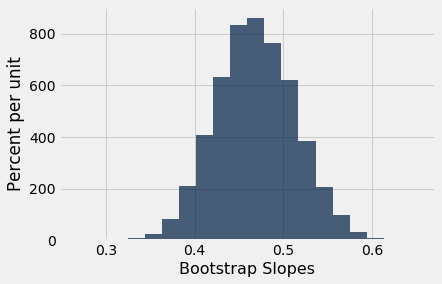

In [10]:
Table().with_column('Bootstrap Slopes', slopes).hist(bins=20)

We can then construct an approximate 95% confidence interval for the slope of the true line, using the bootstrap percentile method. The confidence interval extends from the 2.5th percentile to the 97.5th percentile of the 5000 bootstrapped slopes.

In [11]:
left = percentile(2.5, slopes)
right = percentile(97.5, slopes)
left, right

(0.38420891823731312, 0.55785630851304302)

An approximate 95% confidence interval for the true slope extends from about 0.38 ounces per day to about 0.56 ounces per day. 

### A Function to Bootstrap the Slope ###

Let us collect all the steps of our method of estimating the slope and define a function `bootstrap_slope` that carries them out. Its arguments are the name of the table and the labels of the predictor and response variables, and the desired number of bootstrap replications. In each replication, the function bootstraps the original scatter plot and calculates the slope of the resulting regression line. It then draws the histogram of all the generated slopes and prints the interval consisting of the "middle 95%" of the slopes. 

In [12]:
def bootstrap_slope(table, x, y, repetitions):
    
    # For each repetition:
    # Bootstrap the scatter, get the slope of the regression line,
    # augment the list of generated slopes
    slopes = make_array()
    for i in np.arange(repetitions):
        bootstrap_sample = table.sample()
        bootstrap_slope = slope(bootstrap_sample, x, y)
        slopes = np.append(slopes, bootstrap_slope)
    
    # Find the endpoints of the 95% confidence interval for the true slope
    left = percentile(2.5, slopes)
    right = percentile(97.5, slopes)
    
    # Slope of the regression line from the original sample
    observed_slope = slope(table, x, y)
    
    # Display results
    Table().with_column('Bootstrap Slopes', slopes).hist(bins=20)
    plots.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8);
    print('Slope of regression line:', observed_slope)
    print('Approximate 95%-confidence interval for the true slope:')
    print(left, right)

When we call `bootstrap_slope` to find a confidence interval for the true slope when the response variable is birth weight and the predictor is gestational days, we get an interval very close to the one we obtained earlier: approximately 0.38 ounces per day to 0.56 ounces per day.

Slope of regression line: 0.466556876949
Approximate 95%-confidence interval for the true slope:
0.384092576829 0.561386933725


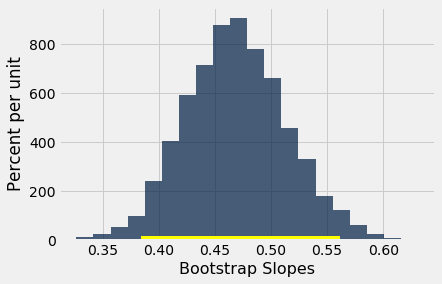

In [13]:
bootstrap_slope(baby, 'Gestational Days', 'Birth Weight', 5000)

Now that we have a function that automates our process of estimating the slope of the true line in a regression model, we can use it on other variables as well.

For example, let's examine the relation between birth weight and the mother's height. Do taller women tend to have heavier babies?

The regression model seems reasonable, based on the scatter plot, but the correlation is not high. It's just about 0.2.

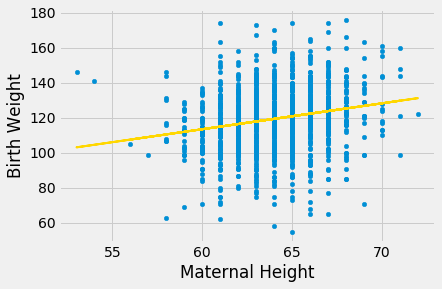

In [14]:
scatter_fit(baby, 'Maternal Height', 'Birth Weight')

In [15]:
correlation(baby, 'Maternal Height', 'Birth Weight')

0.20370417718968034

As before, we can use `bootstrap_slope` to estimate the slope of the true line in the regression model.

Slope of regression line: 1.47801935193
Approximate 95%-confidence interval for the true slope:
1.04805855626 1.90854379963


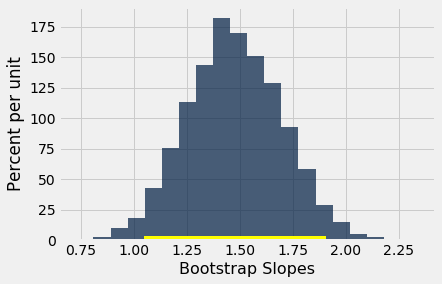

In [16]:
bootstrap_slope(baby, 'Maternal Height', 'Birth Weight', 5000)

A 95% confidence interval for the true slope extends from about 1 ounce per inch to about 1.9 ounces per inch.

### Could the True Slope Be 0? ###

Suppose we believe that our data follow the regression model, and we fit the regression line to estimate the true line. If the regression line isn't perfectly flat, as is almost invariably the case, we will be observing some linear association in the scatter plot.

But what if that observation is spurious? In other words, what if the true line was flat – that is, there was no linear relation between the two variables – and the association that we observed was just due to randomness in generating the points that form our sample?

Here is a simulation that illustrates why this question arises. We will once again call the function ``draw_and_compare``, this time requiring the true line to have slope 0. Our goal is to see whether our regression line shows a slope that is not 0.

Remember that the arguments to the function ``draw_and_compare`` are the slope and the intercept of the true line, and the number of points to be generated.

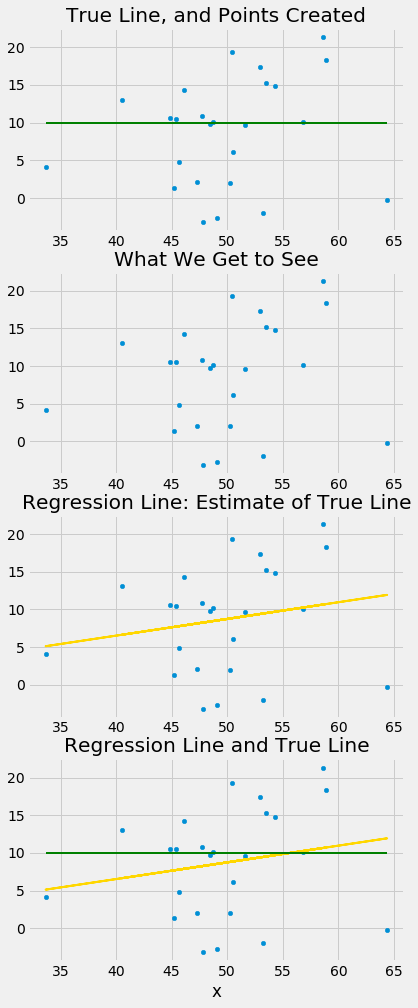

In [17]:
draw_and_compare(0, 10, 25)

Run the simulation a few times, keeping the slope of the true line 0 each time. You will notice that while the slope of the true line is 0, the slope of the regression line is typically not 0. The regression line sometimes slopes upwards, and sometimes downwards, each time giving us a false impression that the two variables are correlated.

To decide whether or not the slope that we are seeing is real, we would like to test the following hypotheses:

**Null Hypothesis.** The slope of the true line is 0. 

**Alternative Hypothesis.** The slope of the true line is not 0. 

We are well positioned to do this. Since we can construct a 95% confidence interval for the true slope, all we have to do is see whether the interval contains 0. 

If it doesn't, then we can reject the null hypothesis (with the 5% cutoff for the P-value). 

If the confidence interval for the true slope does contain 0, then we don't have enough evidence to reject the null hypothesis. Perhaps the slope that we are seeing is spurious.

Let's use this method in an example. Suppose we try to estimate the birth weight of the baby based on the mother's age. Based on the sample, the slope of the regression line for estimating birth weight based on maternal age is positive, about 0.08 ounces per year. 

In [18]:
slope(baby, 'Maternal Age', 'Birth Weight')

0.085007669415825132

Though the slope is positive, it's pretty small. The regression line is so close to flat that it raises the question of whether the true line is flat.

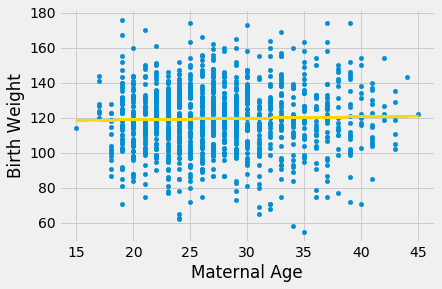

In [19]:
scatter_fit(baby, 'Maternal Age', 'Birth Weight')

We can use `bootstrap_slope` to estimate the slope of the true line. The calculation shows that an approximate 95% bootstrap confidence interval for the true slope has a negative left end point and a positive right end point – in other words, the interval contains 0. 

Slope of regression line: 0.0850076694158
Approximate 95%-confidence interval for the true slope:
-0.0984720496687 0.271658402099


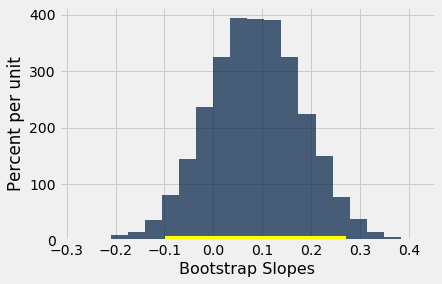

In [20]:
bootstrap_slope(baby, 'Maternal Age', 'Birth Weight', 5000)

Because the interval contains 0, we cannot reject the null hypothesis that the slope of the true linear relation between maternal age and baby's birth weight is 0. Based on this analysis, it would be unwise to predict birth weight based on the regression model with maternal age as the predictor.